In [42]:
# distilBERT implementation and analyses
# Eunbin S Kim 2024
# Data Cleaning and Simple Exploratory Script for the following dataset:
# https://www.kaggle.com/datasets/williamscott701/memotion-dataset-7k


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
from PIL import Image
import os, sys
#from wordcloud import WordCloud, STOPWORDS
warnings.filterwarnings('ignore')
%matplotlib inline
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import time


In [2]:
!pip install transformers


In [3]:
#loading DistilBert
import torch
#from transformers import BertTokenizer, BertModel
from transformers import DistilBertTokenizer, DistilBertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
#matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
from sklearn.metrics.pairwise import cosine_similarity
model = DistilBertModel.from_pretrained("distilbert-base-uncased")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [4]:
# upload meme text data file and drop NAs
labelfile = ('/content/labels.csv')
DB = pd.read_csv(labelfile).dropna()
DB = DB.reset_index(drop = True)

In [5]:
import random
# Set a random seed
random_seed = 42
random.seed(random_seed)

# Set a random seed for PyTorch (for GPU as well)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)


In [6]:
# save cleaned datafile to csv
DB.to_csv('cleaned_labels.csv', index=False)

In [7]:
DB

,Unnamed: 0,image_name,text_ocr,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment
0,0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,hilarious,general,not_offensive,not_motivational,very_positive
1,1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational,very_positive
2,2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,Sam Thorne @Strippin ( Follow Follow Saw every...,very_funny,not_sarcastic,not_offensive,not_motivational,positive
3,3,image_4.png,10 Year Challenge - Sweet Dee Edition,10 Year Challenge - Sweet Dee Edition,very_funny,twisted_meaning,very_offensive,motivational,positive
4,4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,hilarious,very_twisted,very_offensive,not_motivational,neutral
...,...,...,...,...,...,...,...,...,...
6825,6987,image_6988.jpg,Tuesday is Mardi Gras Wednesday is Valentine's...,Tuesday is Mardi Gras Wednesday is Valentine's...,very_funny,twisted_meaning,very_offensive,motivational,neutral
6826,6988,image_6989.jpg,MUST WATCH MOVIES OF 2017 ITI Chennai memes MA...,MUST WATCH MOVIES OF 2017 ITI Chennai memes MA...,funny,twisted_meaning,not_offensive,not_motivational,neutral
6827,6989,image_6990.png,LESS MORE TALKING PLANNING SODA JUNK FOOD COMP...,LESS MORE TALKING PLANNING SODA JUNK FOOD COMP...,funny,general,slight,not_motivational,positive
6828,6990,image_6991.jpg,When I VERY have time is a fantasy No one has ...,When I have time is a fantasy. no one has time...,not_funny,twisted_meaning,not_offensive,motivational,very_positive


In [8]:
Sentiments_only = DB[['humour','sarcasm','offensive','motivational','overall_sentiment']]
map_humour = {'hilarious':3, 'very_funny':2, 'funny':1 , 'not_funny':0}
map_sarcasm = {'not_sarcastic':0, 'general':1, 'twisted_meaning':2, 'very_twisted':3}
map_offensive = {'not_offensive':0, 'slight':1, 'very_offensive':2, 'hateful_offensive':3}
map_motivational = {'not_motivational':0, 'motivational': 1}
map_sentiment = {'very_negative': -2, 'negative': -1, 'neutral': 0, 'positive':1, 'very_positive': 2}
# Note: more humorous/sarcastic/offensive = higher score.

Sentiments_only['humour'] = Sentiments_only['humour'].replace(map_humour)
Sentiments_only['sarcasm'] = Sentiments_only['sarcasm'].replace(map_sarcasm)
Sentiments_only['offensive'] = Sentiments_only['offensive'].replace(map_offensive)
Sentiments_only['motivational'] = Sentiments_only['motivational'].replace(map_motivational)
Sentiments_only['overall_sentiment'] = Sentiments_only['overall_sentiment'].replace(map_sentiment)

Sentiments_only

,humour,sarcasm,offensive,motivational,overall_sentiment
0,3,1,0,0,2
1,0,1,0,1,2
2,2,0,0,0,1
3,2,2,2,1,1
4,3,3,2,0,0
...,...,...,...,...,...
6825,2,2,2,1,0
6826,1,2,0,0,0
6827,1,1,1,0,1
6828,0,2,0,1,2


In [9]:
type(Sentiments_only)

pandas.core.frame.DataFrame

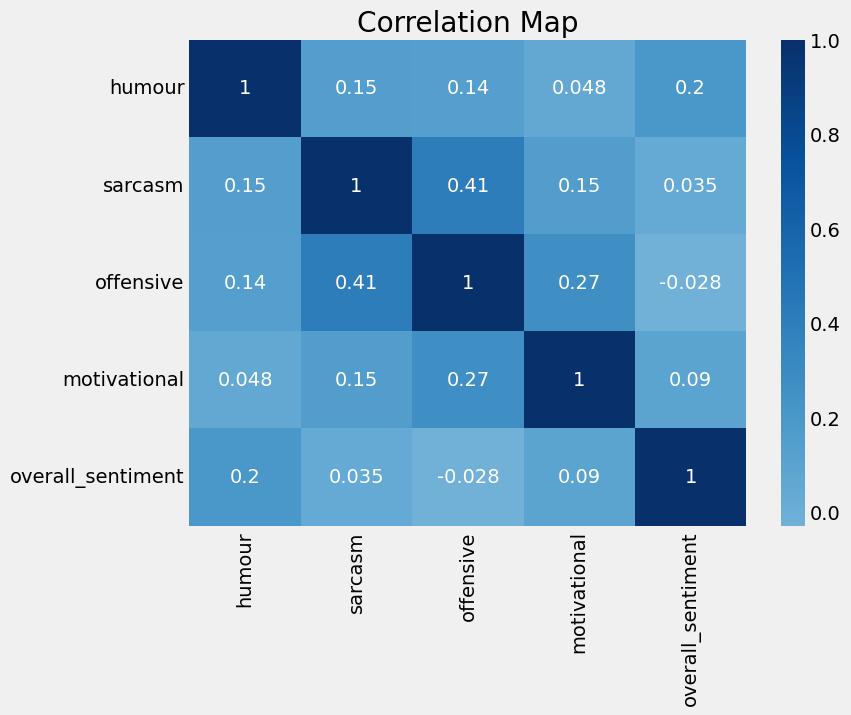

In [10]:
# Correlation between ratings.
S_corr = Sentiments_only.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(S_corr, annot=True, cmap='Blues', center=0)
plt.title('Correlation Map')
plt.show()
# Interpretation? Sarcasm can be offensive. Very intuitive.

In [11]:
# Now work with the Captions/Texts.
import re
import nltk
#nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize


def text_to_set_np(row):
    # if we want to exclude the punctuation, but so far let's just use the easy way.
    row = re.sub(r'[^a-zA-Z0-9 ]+','',row)
    #row = re.sub(r'[^a-zA-Z0-9.,!?:; ]+','',row)
    row = row.lower().split()
    return row


def remove_watermark(row):
    patterns = [r".*com.*", r".*net.*", r".*co.*",r".*mobi.*", r".*modi.*", r"meme center", r"memecenter", r"memedroid",r"memetenler",r'avengermemes']
    combined_pattern = re.compile("|".join(patterns))
    for idx in range(len(row)-1,-1,-1):
        if combined_pattern.match(row[idx]):
            row.pop(idx)
    return row

def join_row(row):
    return ' '.join(map(str,row))



TXT_p= pd.DataFrame(DB['text_corrected']).applymap(text_to_set_np)
TXT_p = TXT_p.applymap(remove_watermark) #with punctuation
TXT_p = TXT_p.applymap(join_row)


#TXT_np= pd.DataFrame(DB['text_corrected']).applymap(text_to_set_np)
#TXT_np = TXT_np.applymap(remove_watermark) #without punctuation

print(TXT_p)
# Notes
# Several things to take care of:
# 1) get rid of all the special characters. (done)
# 2) site names like memegenerator.com (done)
# 3) Tentatively: Use word2vec(CBOW)/CoVe/BERT




                                         text_corrected
0     look there my friend lightyear now all sohalik...
1     the best of 10 yearchallenge in less the 4 yea...
2     sam thorne strippin follow follow saw everyone...
3                   10 year challenge sweet dee edition
4     10 year challenge with no filter 47 hilarious ...
...                                                 ...
6825  tuesday is mardi gras wednesday is valentines ...
6826  must watch movies of 2017 iti chennai memes ma...
6827  less more talking planning soda junk food worr...
6828  when i have time is a fantasy no one has time ...
6829  the starting point for every good idea is what...

[6830 rows x 1 columns]


In [12]:
# Input text
text = DB['text_corrected']

In [13]:
text

,text_corrected
0,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...
1,The best of #10 YearChallenge! Completed in le...
2,Sam Thorne @Strippin ( Follow Follow Saw every...
3,10 Year Challenge - Sweet Dee Edition
4,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...
...,...
6825,Tuesday is Mardi Gras Wednesday is Valentine's...
6826,MUST WATCH MOVIES OF 2017 ITI Chennai memes MA...
6827,LESS MORE TALKING PLANNING SODA JUNK FOOD COMP...
6828,When I have time is a fantasy. no one has time...


In [14]:
type(TXT_p)

pandas.core.frame.DataFrame

In [15]:
TXT_p

,text_corrected
0,look there my friend lightyear now all sohalik...
1,the best of 10 yearchallenge in less the 4 yea...
2,sam thorne strippin follow follow saw everyone...
3,10 year challenge sweet dee edition
4,10 year challenge with no filter 47 hilarious ...
...,...
6825,tuesday is mardi gras wednesday is valentines ...
6826,must watch movies of 2017 iti chennai memes ma...
6827,less more talking planning soda junk food worr...
6828,when i have time is a fantasy no one has time ...


In [16]:
# Further pre-processing step
# Lemmatization - reduce words to their base or dictionary form (known as the lemma)

import spacy

# Load SpaCy for lemmatization
nlp = spacy.load('en_core_web_sm')# Lemmatization

# Function to lemmatize text
def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

# Apply lemmatization to the 'text_corrected' column
TXT_p['lemmatized_text'] = TXT_p['text_corrected'].apply(lemmatize_text)

# Display the DataFrame with the new lemmatized text column



print(TXT_p[['text_corrected', 'lemmatized_text']].head())

                                      text_corrected  \
0  look there my friend lightyear now all sohalik...   
1  the best of 10 yearchallenge in less the 4 yea...   
2  sam thorne strippin follow follow saw everyone...   
3                10 year challenge sweet dee edition   
4  10 year challenge with no filter 47 hilarious ...   

                                     lemmatized_text  
0  look there my friend lightyear now all sohalik...  
1  the good of 10 yearchallenge in less the 4 yea...  
2  sam thorne strippin follow follow see everyone...  
3                10 year challenge sweet dee edition  
4  10 year challenge with no filter 47 hilarious ...  


In [17]:
#import necessary packages for preprocessing
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [18]:
# One more pre-processing step
# Removing stop words using NLTK before feeding into BERT
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# turn the lemmatized text into a list from the TXT_p dataframe
text = TXT_p['lemmatized_text'].tolist()

# Get English stop words
stop_words = set(stopwords.words('english'))

# List to hold the filtered text
filtered_text_list = []

# Iterate over each string in the text list
for sentence in text:
    # Tokenize and remove stop words
    tokens = word_tokenize(sentence)
    filtered_sentence = " ".join([word for word in tokens if word.lower() not in stop_words])

    # Append the filtered sentence to the list
    filtered_text_list.append(filtered_sentence)

# Convert the list back to a DataFrame column
TXT_p['filtered_text'] = filtered_text_list

print(TXT_p[['lemmatized_text', 'filtered_text']].head())

                                     lemmatized_text  \
0  look there my friend lightyear now all sohalik...   
1  the good of 10 yearchallenge in less the 4 yea...   
2  sam thorne strippin follow follow see everyone...   
3                10 year challenge sweet dee edition   
4  10 year challenge with no filter 47 hilarious ...   

                                       filtered_text  
0  look friend lightyear sohalikut trend play 10 ...  
1  good 10 yearchallenge less 4 year kudus ji 805...  
2  sam thorne strippin follow follow see everyone...  
3                10 year challenge sweet dee edition  
4  10 year challenge filter 47 hilarious 10 year ...  


In [23]:
TXT_p[['filtered_text']].to_csv('filtered_text.csv', index=False)

In [20]:
labeled_pp = TXT_p.join(Sentiments_only)

In [21]:
labeled_pp

,text_corrected,lemmatized_text,filtered_text,humour,sarcasm,offensive,motivational,overall_sentiment
0,look there my friend lightyear now all sohalik...,look there my friend lightyear now all sohalik...,look friend lightyear sohalikut trend play 10 ...,3,1,0,0,2
1,the best of 10 yearchallenge in less the 4 yea...,the good of 10 yearchallenge in less the 4 yea...,good 10 yearchallenge less 4 year kudus ji 805...,0,1,0,1,2
2,sam thorne strippin follow follow saw everyone...,sam thorne strippin follow follow see everyone...,sam thorne strippin follow follow see everyone...,2,0,0,0,1
3,10 year challenge sweet dee edition,10 year challenge sweet dee edition,10 year challenge sweet dee edition,2,2,2,1,1
4,10 year challenge with no filter 47 hilarious ...,10 year challenge with no filter 47 hilarious ...,10 year challenge filter 47 hilarious 10 year ...,3,3,2,0,0
...,...,...,...,...,...,...,...,...
6825,tuesday is mardi gras wednesday is valentines ...,tuesday be mardi gras wednesday be valentine f...,tuesday mardi gras wednesday valentine friday ...,2,2,2,1,0
6826,must watch movies of 2017 iti chennai memes ma...,must watch movie of 2017 iti chennai meme maan...,must watch movie 2017 iti chennai meme maanaga...,1,2,0,0,0
6827,less more talking planning soda junk food worr...,less more talk plan soda junk food worry doubt...,less talk plan soda junk food worry doubt laze...,1,1,1,0,1
6828,when i have time is a fantasy no one has time ...,when I have time be a fantasy no one have time...,time fantasy one time unless make time,0,2,0,1,2


In [22]:
labeled_pp['class_sarc'] = labeled_pp['sarcasm'].apply(lambda x: 1 if x > 0 else 0)
labeled_pp

,text_corrected,lemmatized_text,filtered_text,humour,sarcasm,offensive,motivational,overall_sentiment,class_sarc
0,look there my friend lightyear now all sohalik...,look there my friend lightyear now all sohalik...,look friend lightyear sohalikut trend play 10 ...,3,1,0,0,2,1
1,the best of 10 yearchallenge in less the 4 yea...,the good of 10 yearchallenge in less the 4 yea...,good 10 yearchallenge less 4 year kudus ji 805...,0,1,0,1,2,1
2,sam thorne strippin follow follow saw everyone...,sam thorne strippin follow follow see everyone...,sam thorne strippin follow follow see everyone...,2,0,0,0,1,0
3,10 year challenge sweet dee edition,10 year challenge sweet dee edition,10 year challenge sweet dee edition,2,2,2,1,1,1
4,10 year challenge with no filter 47 hilarious ...,10 year challenge with no filter 47 hilarious ...,10 year challenge filter 47 hilarious 10 year ...,3,3,2,0,0,1
...,...,...,...,...,...,...,...,...,...
6825,tuesday is mardi gras wednesday is valentines ...,tuesday be mardi gras wednesday be valentine f...,tuesday mardi gras wednesday valentine friday ...,2,2,2,1,0,1
6826,must watch movies of 2017 iti chennai memes ma...,must watch movie of 2017 iti chennai meme maan...,must watch movie 2017 iti chennai meme maanaga...,1,2,0,0,0,1
6827,less more talking planning soda junk food worr...,less more talk plan soda junk food worry doubt...,less talk plan soda junk food worry doubt laze...,1,1,1,0,1,1
6828,when i have time is a fantasy no one has time ...,when I have time be a fantasy no one have time...,time fantasy one time unless make time,0,2,0,1,2,1


In [24]:
# saving separate labels for later classification use
labeled_pp[['class_sarc']].to_csv('sarcasm_labels.csv', index=False)


In [25]:
## distilBERT tokenization step- after preprocessing with lemmatization and stop words

# Input text
text = TXT_p['filtered_text'].tolist()  # Convert final preprocessed text to list including lemmatization and stop words step

# Tokenize and encode text using batch_encode_plus
# The function returns a dictionary containing the token IDs and attention masks
encoding = tokenizer.batch_encode_plus(
    text,                     # List of input texts
    padding=True,             # Pad to the maximum sequence length
    truncation=True,          # Truncate to the maximum sequence length if necessary
    return_tensors='pt',      # Return PyTorch tensors
    add_special_tokens=True   # Add special tokens CLS and SEP
)

input_ids = encoding['input_ids']  # Token IDs
# Print input IDs
print(f"Input IDs: {input_ids}")

attention_mask = encoding['attention_mask']  # Attention mask
# Print attention mask
print(f"Attention mask: {attention_mask}")

Input IDs: tensor([[  101,  2298,  2767,  ...,     0,     0,     0],
        [  101,  2204,  2184,  ...,     0,     0,     0],
        [  101,  3520, 14296,  ...,     0,     0,     0],
        ...,
        [  101,  2625,  2831,  ...,     0,     0,     0],
        [  101,  2051,  5913,  ...,     0,     0,     0],
        [  101,  3225,  2391,  ...,     0,     0,     0]])
Attention mask: tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])


In [26]:

# Generate embeddings using distilBERT model
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    word_embeddings = outputs.last_hidden_state  # This contains the embeddings

# Output the shape of word embeddings
print(f"Shape of Word Embeddings: {word_embeddings.shape}")


Shape of Word Embeddings: torch.Size([6830, 132, 768])


In [27]:

# Decode the token IDs back to text
decoded_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
#print decoded text
print(f"Decoded Text: {decoded_text}")
# Tokenize the text again for reference
tokenized_text = tokenizer.tokenize(decoded_text)
#print tokenized text
print(f"tokenized Text: {tokenized_text}")
# Encode the text
encoded_text = tokenizer.encode(text, return_tensors='pt')  # Returns a tensor
# Print encoded text
print(f"Encoded Text: {encoded_text}")


Token indices sequence length is longer than the specified maximum sequence length for this model (6832 > 512). Running this sequence through the model will result in indexing errors


Decoded Text: look friend lightyear sohalikut trend play 10 year challenge facebook
tokenized Text: ['look', 'friend', 'light', '##year', 'so', '##hal', '##ik', '##ut', 'trend', 'play', '10', 'year', 'challenge', 'facebook']
Encoded Text: tensor([[101, 100, 100,  ..., 100, 100, 102]])


In [28]:

# Print word embeddings for each token
for token, embedding in zip(tokenized_text, word_embeddings[0]):
    #print(f"Token: {token}")
    print(f"Embedding: {embedding}")
    print("\n")


Embedding: tensor([-8.7871e-02, -2.2617e-01, -4.7691e-03, -6.8208e-02, -3.5666e-02,
        -1.6888e-01,  3.7214e-01,  4.8093e-01, -2.3071e-01, -2.3045e-01,
         1.0439e-01, -2.7866e-01,  6.9017e-02,  2.7276e-01,  2.9737e-02,
        -1.0599e-02, -1.6536e-01,  4.1700e-01,  2.3341e-01, -3.3543e-02,
         1.0656e-01, -4.2552e-01,  2.1236e-01, -2.5665e-02,  9.6469e-02,
         5.2194e-02,  1.1407e-01,  3.0074e-02,  2.4562e-01,  6.5582e-02,
         4.2049e-02,  1.2659e-01, -4.9155e-02, -2.0780e-01,  6.9646e-02,
        -1.3140e-01,  1.6448e-01,  8.0473e-04,  5.3187e-02,  3.0524e-01,
        -1.5143e-01, -1.7740e-01,  1.4746e-01,  8.8223e-02,  1.0601e-01,
        -1.6976e-01, -2.5043e+00,  8.1593e-02, -1.2585e-01, -1.2617e-01,
         2.0931e-01, -1.2970e-02,  1.0507e-01,  1.5325e-01,  2.8466e-01,
         5.7305e-01,  8.5382e-02,  2.9411e-01, -7.2068e-02,  1.5512e-01,
         4.4942e-02,  1.4768e-01, -2.0430e-01, -2.1629e-01, -1.8704e-01,
        -6.7682e-02, -1.1035e-01,  3.382

In [29]:

# Compute the average of word embeddings to get the sentence embedding
sentence_embedding = word_embeddings.mean(dim=1)  # Average pooling along the sequence length dimension

# Print the sentence embedding
print("Sentence Embedding:")
print(sentence_embedding)

# Output the shape of the sentence embedding
print(f"Shape of Sentence Embedding: {sentence_embedding.shape}")


Sentence Embedding:
tensor([[ 0.0255, -0.1935,  0.3135,  ...,  0.0284, -0.1075,  0.2365],
        [ 0.0363, -0.2038,  0.4115,  ..., -0.0711,  0.0126,  0.1218],
        [ 0.1450,  0.0242,  0.4459,  ..., -0.0352,  0.0749,  0.0649],
        ...,
        [ 0.0440,  0.2090,  0.3747,  ...,  0.0344, -0.1280, -0.0256],
        [ 0.0963, -0.3538,  0.3915,  ..., -0.0583, -0.1792,  0.0484],
        [-0.0589,  0.0701,  0.1721,  ..., -0.0929, -0.0473,  0.1717]])
Shape of Sentence Embedding: torch.Size([6830, 768])


In [32]:
# Convert tensor to numpy array
sentence_embedding_np = sentence_embedding.numpy()

# Save to CSV
pd.DataFrame(sentence_embedding_np).to_csv('sentence_embeddings.csv', index=False)

In [33]:
pd.DataFrame(labeled_pp[['class_sarc']]).to_csv('sarcasm_labels.csv', index=False)

In [34]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Assuming sentence_embedding is a tensor of shape (n_sentences, embedding_dim)
sentence_embedding_np = sentence_embedding.detach().cpu().numpy()  # Convert to NumPy array

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(sentence_embedding_np)

# Print the shape of PCA result
print(f"Shape of PCA Result: {pca_result.shape}")

Shape of PCA Result: (6830, 2)


In [35]:
# Extract sentiment labels from the dataframe
sentiment_labels = labeled_pp['class_sarc'].tolist()  # sarcasm or not labels

# Ensure sentiment_labels and sentence_embedding_np have the same length
assert len(sentiment_labels) == sentence_embedding_np.shape[0]

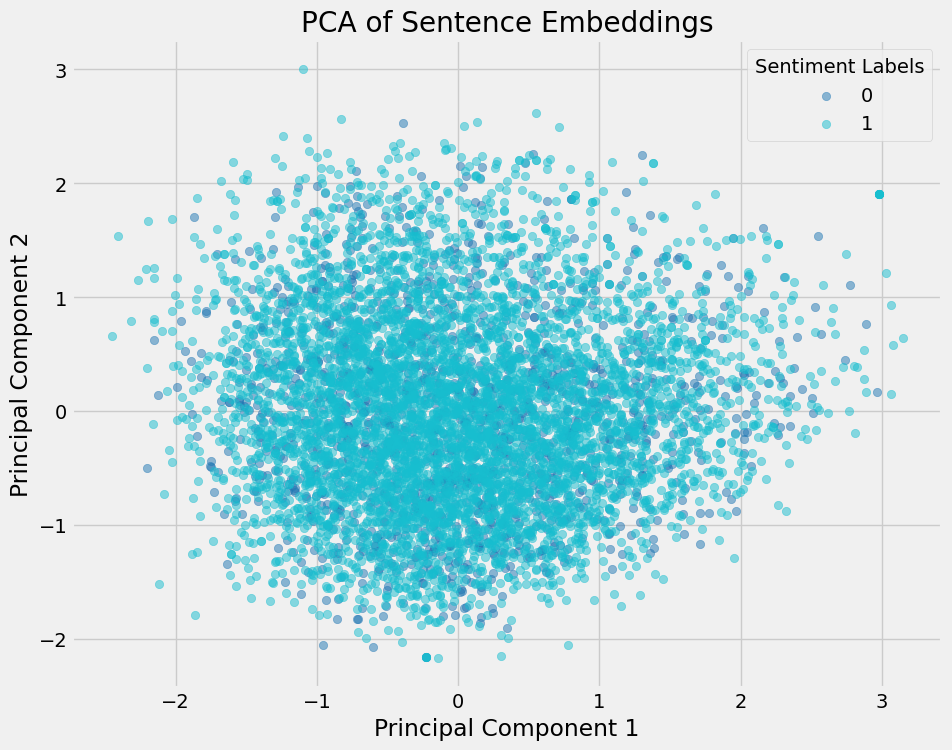

In [36]:
# Map sentiment labels to colors
unique_labels = list(set(sentiment_labels))
colors = plt.cm.get_cmap('tab10', len(unique_labels))

# Plot the PCA result
plt.figure(figsize=(10, 8))
for i, label in enumerate(unique_labels):
    indices = [j for j, x in enumerate(sentiment_labels) if x == label]
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1],
                label=label,
                color=colors(i),
                alpha=0.5)

plt.title('PCA of Sentence Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Sentiment Labels')
plt.show()

In [37]:
import torch.nn.functional as F

# Assuming sentence_embeddings is a tensor of shape (n_sentences, embedding_dim)
# where n_sentences is the number of sentences and embedding_dim is the size of each embedding.
# For example, sentence_embeddings might be of shape (100, 768) if you have 100 sentences
# and each embedding has 768 dimensions.

# Normalize the sentence embeddings to unit vectors
normalized_embedding = F.normalize(sentence_embedding, p=2, dim=1)

# Compute cosine similarity between all pairs
cosine_sim_matrix = torch.mm(normalized_embedding, normalized_embedding.T)

# Output the cosine similarity matrix
print("Cosine Similarity Matrix:")
print(cosine_sim_matrix)


Cosine Similarity Matrix:
tensor([[1.0000, 0.8669, 0.8309,  ..., 0.8095, 0.7128, 0.7987],
        [0.8669, 1.0000, 0.8741,  ..., 0.7986, 0.7270, 0.8033],
        [0.8309, 0.8741, 1.0000,  ..., 0.8014, 0.7334, 0.7828],
        ...,
        [0.8095, 0.7986, 0.8014,  ..., 1.0000, 0.7189, 0.7584],
        [0.7128, 0.7270, 0.7334,  ..., 0.7189, 1.0000, 0.7598],
        [0.7987, 0.8033, 0.7828,  ..., 0.7584, 0.7598, 1.0000]])


In [38]:
import pandas as pd

# Assuming cosine_sim_matrix is your cosine similarity matrix
# Convert the tensor to a NumPy array
cosine_sim_matrix_np = cosine_sim_matrix.numpy()

# Create a Pandas DataFrame from the NumPy array
cosine_sim_df = pd.DataFrame(cosine_sim_matrix_np)

# Optionally, you can add row and column labels
# For example, if you have a list of sentence IDs or labels:
# sentence_labels = ["sentence_1", "sentence_2", ..., "sentence_n"]
# cosine_sim_df.columns = sentence_labels
# cosine_sim_df.index = sentence_labels

# Export the DataFrame to a CSV file
cosine_sim_df.to_csv("cosine_similarity_matrix.csv", index=False)

print("Cosine similarity matrix exported to 'cosine_similarity_matrix.csv'")

Cosine similarity matrix exported to 'cosine_similarity_matrix.csv'


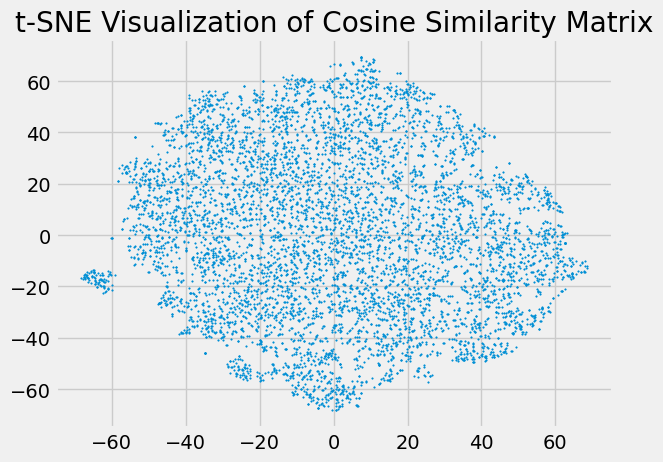

In [39]:
from sklearn.manifold import TSNE

# Use t-SNE with cosine metric directly
tsne = TSNE(n_components=2, random_state=42, metric='cosine')
tsne_results = tsne.fit_transform(cosine_sim_matrix_np)

# Plot the t-SNE results
import matplotlib.pyplot as plt
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=1)
plt.title("t-SNE Visualization of Cosine Similarity Matrix")
plt.show()

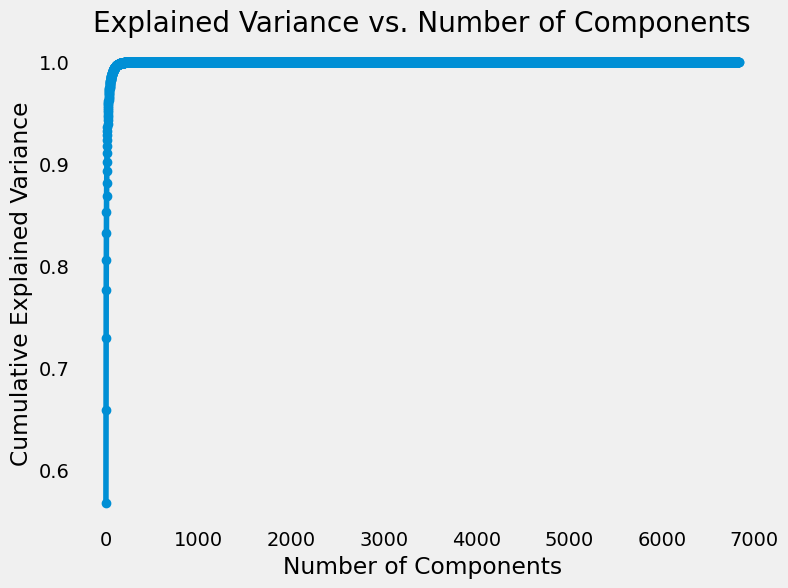

Number of components to retain 95% variance: 22


In [40]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# Plotting to figure out how many components to reduce dimensionality to
# Fit PCA
pca = PCA()
pca.fit(cosine_sim_matrix_np)

# Plot explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()

# Determine number of components to explain 95% variance
explained_variance = 0.95
n_components = next(i for i, cumulative_variance in enumerate(pca.explained_variance_ratio_.cumsum(), 1)
                    if cumulative_variance >= explained_variance)

print(f'Number of components to retain {explained_variance*100:.0f}% variance: {n_components}')

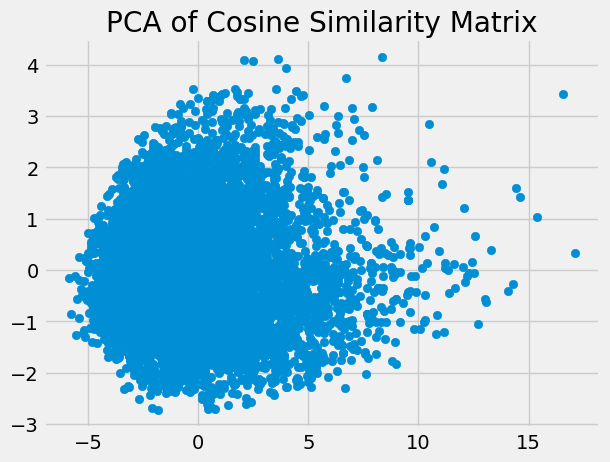

In [ ]:
# dimensionality reduction via PCA

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensionality to 22 components as determined above
pca = PCA(n_components=22)
reduced_data = pca.fit_transform(cosine_sim_matrix_np)

# Plot the reduced data
plt.scatter(reduced_data[:, 0], reduced_data[:, 1])
plt.title("PCA of Cosine Similarity Matrix")
plt.show()

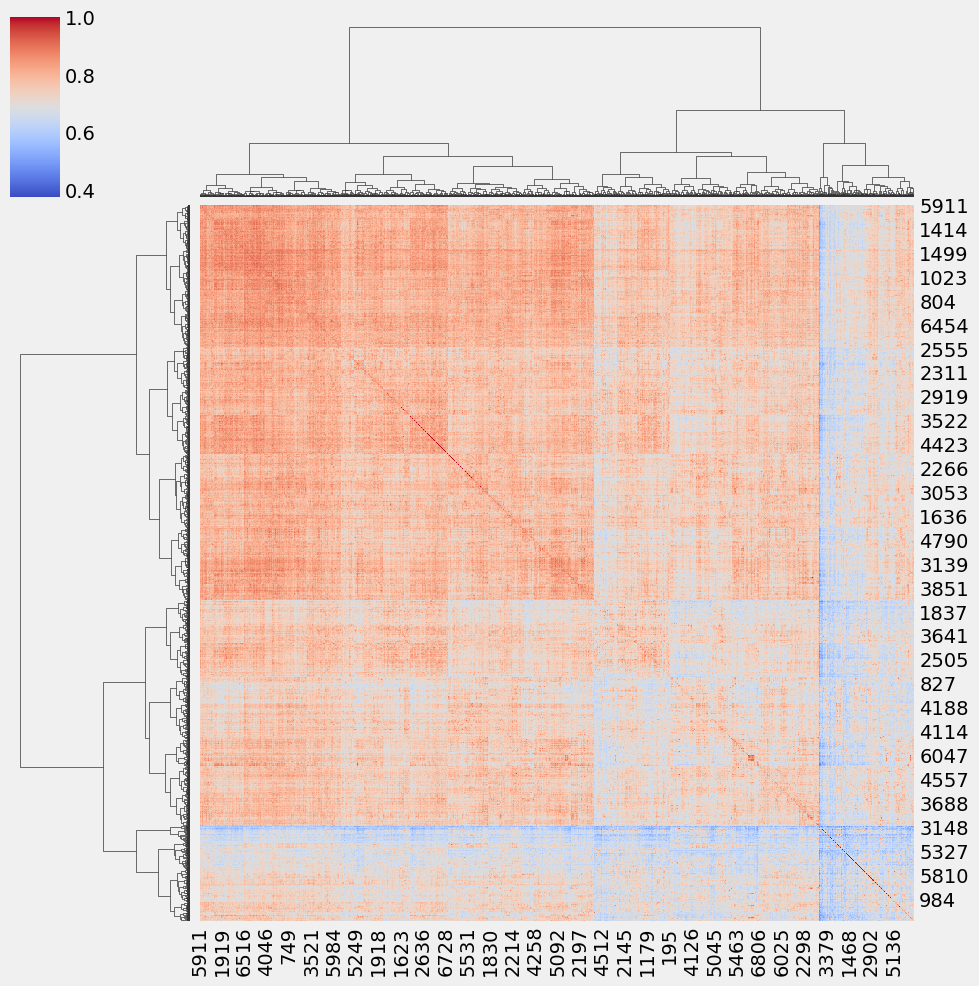

In [ ]:
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram

# Perform hierarchical clustering
linkage_matrix = linkage(cosine_sim_matrix_np, method='ward')

# Plot the clustered heatmap with a dendrogram
sns.clustermap(cosine_sim_matrix_np, row_linkage=linkage_matrix, col_linkage=linkage_matrix, cmap="coolwarm")
plt.show()

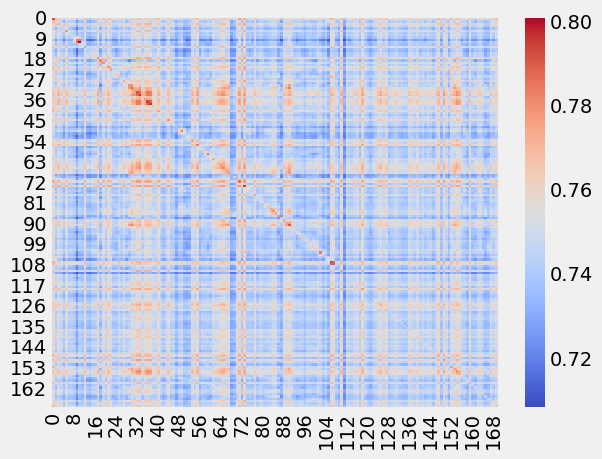

In [ ]:
import numpy as np

def downsample(matrix, factor):
    size = matrix.shape[0] // factor
    return matrix[:size*factor, :size*factor].reshape(size, factor, size, factor).mean(axis=(1, 3))

# Downsample by a factor of 10
downsampled_matrix = downsample(cosine_sim_matrix_np, 40)

# Plot the downsampled heatmap
sns.heatmap(downsampled_matrix, cmap="coolwarm")
plt.show()

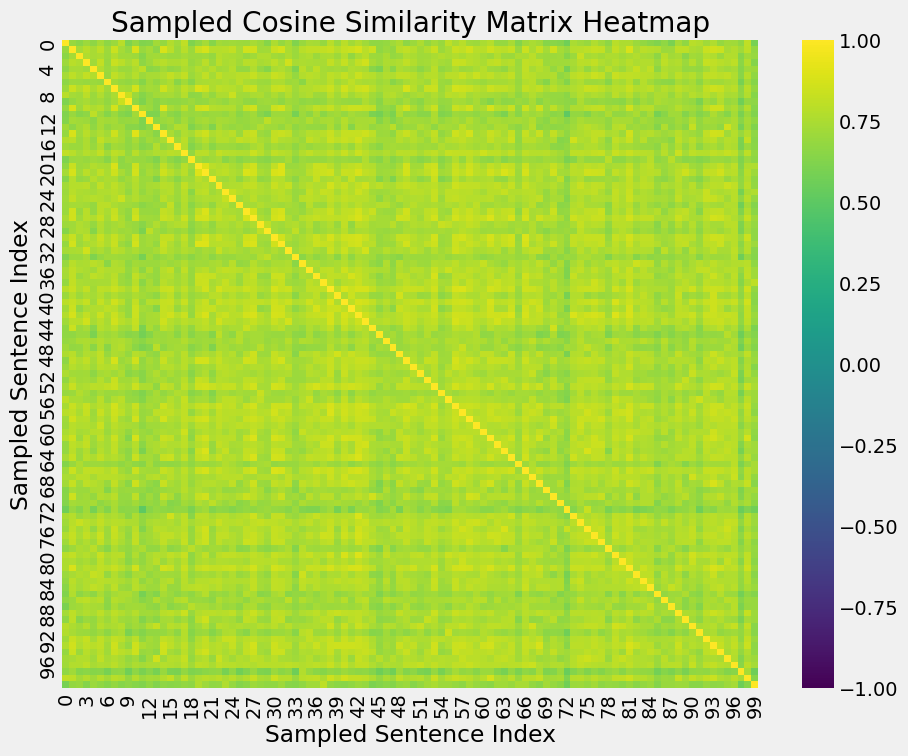

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sample a subset of the cosine similarity matrix
sample_indices = np.random.choice(cosine_sim_matrix_np.shape[0], size=100, replace=False)
sampled_similarities = cosine_sim_matrix_np[sample_indices][:, sample_indices]

# Plot the heatmap for the sampled subset
plt.figure(figsize=(10, 8))
sns.heatmap(sampled_similarities, cmap='viridis', vmin=-1, vmax=1)
plt.title("Sampled Cosine Similarity Matrix Heatmap")
plt.xlabel("Sampled Sentence Index")
plt.ylabel("Sampled Sentence Index")
plt.show()

In [ ]:
import torch
import numpy as np
from scipy.spatial.distance import cdist

# Assuming sentence_embeddings is a tensor of shape (num_sentences, embedding_dim)
# Convert the tensor to a NumPy array
sentence_embedding_np = sentence_embedding.numpy()

# Compute the pairwise Euclidean distances
# cdist computes the distance between each pair of the two collections of inputs.
euclidean_dist_matrix = cdist(sentence_embedding_np, sentence_embedding_np, 'euclidean')

# Convert the distance matrix to a tensor (optional)
euclidean_dist_tensor = torch.tensor(euclidean_dist_matrix)

# Output the shape of the distance matrix
print(f"Shape of Euclidean Distance Matrix: {euclidean_dist_tensor.shape}")

# Print the distance matrix
print(euclidean_dist_tensor)

Shape of Euclidean Distance Matrix: torch.Size([6830, 6830])
tensor([[0.0000, 3.4646, 3.9059,  ..., 4.3445, 5.4843, 4.2557],
        [3.4646, 0.0000, 3.3114,  ..., 4.4194, 5.2992, 4.1314],
        [3.9059, 3.3114, 0.0000,  ..., 4.3910, 5.2403, 4.3451],
        ...,
        [4.3445, 4.4194, 4.3910,  ..., 0.0000, 5.5417, 4.8298],
        [5.4843, 5.2992, 5.2403,  ..., 5.5417, 0.0000, 4.9794],
        [4.2557, 4.1314, 4.3451,  ..., 4.8298, 4.9794, 0.0000]],
       dtype=torch.float64)


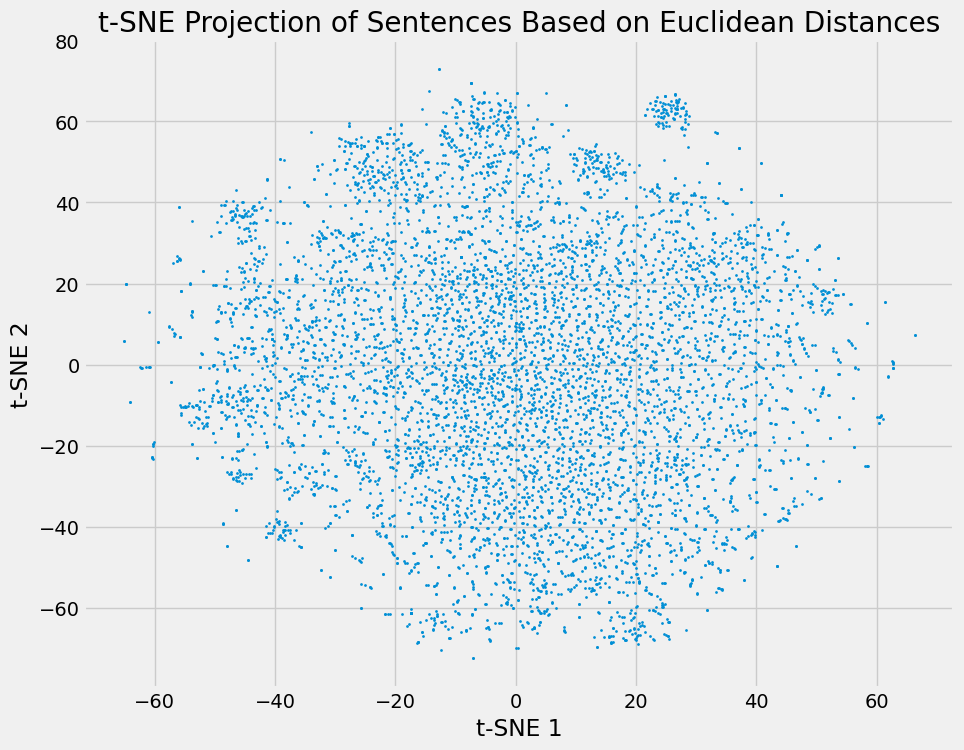

In [ ]:
import numpy as np

# Use t-SNE to reduce dimensionality to 2D with random initialization
tsne = TSNE(n_components=2, metric='precomputed', init='random', random_state=42)
reduced_embeddings = tsne.fit_transform(euclidean_dist_tensor.numpy())

# Plot the 2D projection
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=2)
plt.title("t-SNE Projection of Sentences Based on Euclidean Distances")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

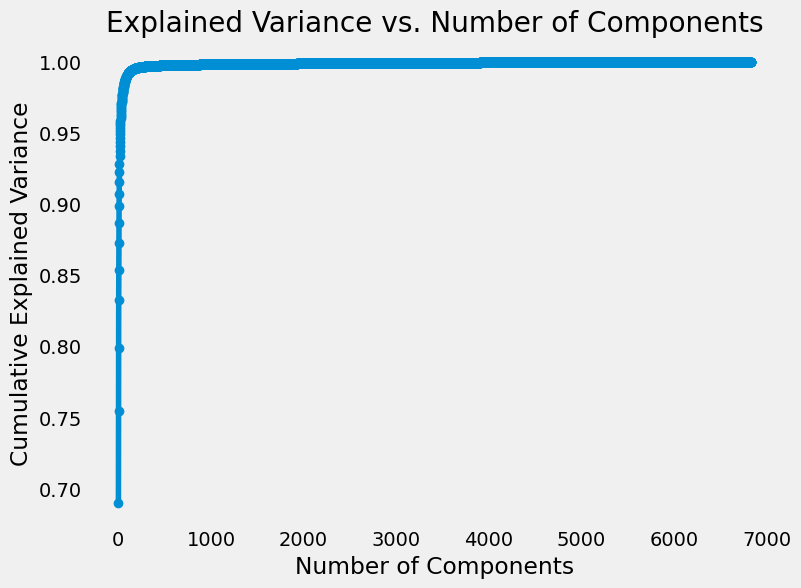

Number of components to retain 95% variance: 19


In [ ]:
# Plotting to figure out how many components to reduce dimensionality to
# Fit PCA
pca = PCA()
pca.fit(euclidean_dist_matrix)

# Plot explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()

# Determine number of components to explain 95% variance
explained_variance = 0.95
n_components = next(i for i, cumulative_variance in enumerate(pca.explained_variance_ratio_.cumsum(), 1)
                    if cumulative_variance >= explained_variance)

print(f'Number of components to retain {explained_variance*100:.0f}% variance: {n_components}')

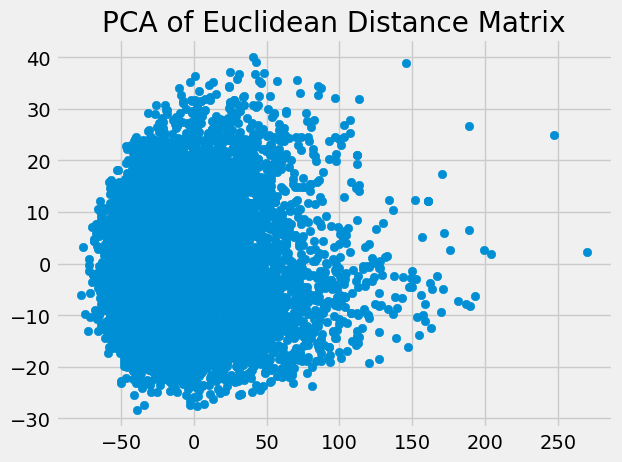

In [ ]:
# dimensionality reduction via PCA

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensionality to 19 components as determined above
pca = PCA(n_components=19)
reduced_data = pca.fit_transform(euclidean_dist_matrix)

# Plot the reduced data
plt.scatter(reduced_data[:, 0], reduced_data[:, 1])
plt.title("PCA of Euclidean Distance Matrix")
plt.show()

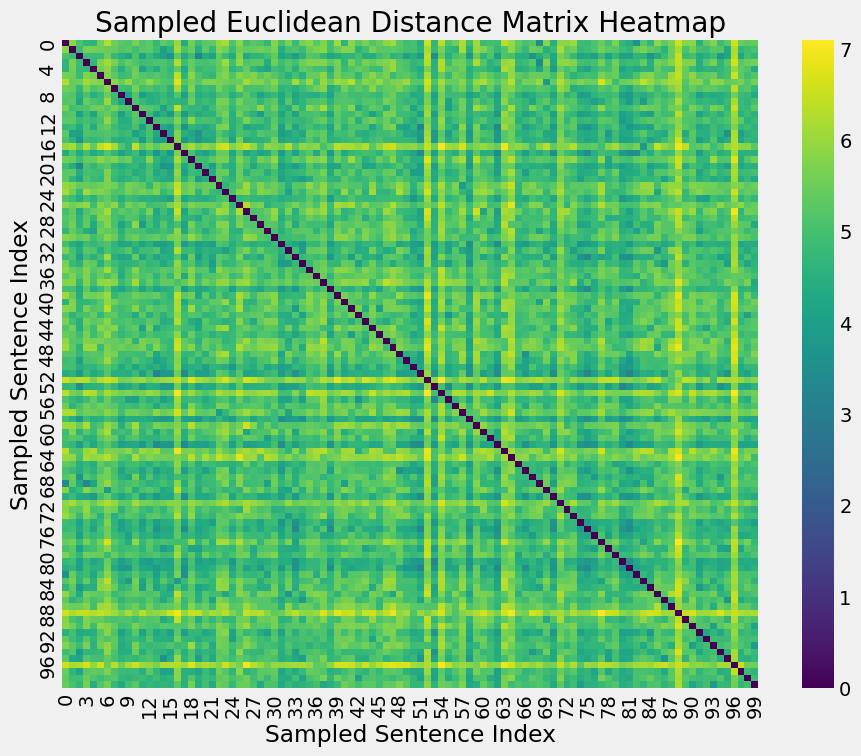

In [ ]:
# Sample a subset of the distance matrix
sample_indices = np.random.choice(euclidean_dist_tensor.size(0), size=100, replace=False)
sampled_distances = euclidean_dist_tensor[sample_indices][:, sample_indices]

# Plot the heatmap for the sampled subset
plt.figure(figsize=(10, 8))
sns.heatmap(sampled_distances.numpy(), cmap='viridis')
plt.title("Sampled Euclidean Distance Matrix Heatmap")
plt.xlabel("Sampled Sentence Index")
plt.ylabel("Sampled Sentence Index")
plt.show()

In [ ]:
TXT_p

,text_corrected,lemmatized_text,filtered_text
0,look there my friend lightyear now all sohalik...,look there my friend lightyear now all sohalik...,look friend lightyear sohalikut trend play 10 ...
1,the best of 10 yearchallenge in less the 4 yea...,the good of 10 yearchallenge in less the 4 yea...,good 10 yearchallenge less 4 year kudus ji 805...
2,sam thorne strippin follow follow saw everyone...,sam thorne strippin follow follow see everyone...,sam thorne strippin follow follow see everyone...
3,10 year challenge sweet dee edition,10 year challenge sweet dee edition,10 year challenge sweet dee edition
4,10 year challenge with no filter 47 hilarious ...,10 year challenge with no filter 47 hilarious ...,10 year challenge filter 47 hilarious 10 year ...
...,...,...,...
6825,tuesday is mardi gras wednesday is valentines ...,tuesday be mardi gras wednesday be valentine f...,tuesday mardi gras wednesday valentine friday ...
6826,must watch movies of 2017 iti chennai memes ma...,must watch movie of 2017 iti chennai meme maan...,must watch movie 2017 iti chennai meme maanaga...
6827,less more talking planning soda junk food worr...,less more talk plan soda junk food worry doubt...,less talk plan soda junk food worry doubt laze...
6828,when i have time is a fantasy no one has time ...,when I have time be a fantasy no one have time...,time fantasy one time unless make time


In [44]:
import torch
print(torch.cuda.is_available())

False


In [54]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score

# Custom Dataset class
class SentenceEmbeddingsDataset(Dataset):
    def __init__(self, embeddings_file, labels_file):
        # Load embeddings and labels from CSV files
        self.embeddings = pd.read_csv(embeddings_file).values
        self.labels = pd.read_csv(labels_file).values

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.embeddings)

    def __getitem__(self, idx):
        # Retrieve a specific sample from the dataset
        embedding = self.embeddings[idx]
        label = self.labels[idx]
        return torch.tensor(embedding, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

# Define the classification model
class ClassificationModel(nn.Module):
    def __init__(self, projection_size):
        super(ClassificationModel, self).__init__()
        self.flat = nn.Flatten()
        self.proj_into_class = nn.Sequential(
            nn.Linear(projection_size, 24),
            nn.GELU(),
            nn.Linear(24, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.flat(x)
        x = self.proj_into_class(x)
        return x

# Function to enable gradients for the classification layer
def set_gradients(model, requires_grad=True):
    for param in model.proj_into_class.parameters():
        param.requires_grad = requires_grad

# Function to load checkpoint (assumed to be defined elsewhere in your codebase)
def load_checkpoint(filepath, model, optimizer):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    return model, optimizer, epoch

# Load dataset
embeddings_file = 'sentence_embeddings.csv'  # Replace with your file path
labels_file = 'sarcasm_labels.csv'          # Replace with your file path

# Create the full dataset
full_dataset = SentenceEmbeddingsDataset(embeddings_file, labels_file)

# Train-test split
train_size = int(0.8 * len(full_dataset))  # 80% of the dataset
test_size = len(full_dataset) - train_size  # 20% of the dataset
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoader for train and test sets with different batch sizes
batch_size = 128  # Example batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
projection_size = 768  # Example size, replace with your projection size
model = ClassificationModel(projection_size)

# Enable gradients for classification layer
set_gradients(model, requires_grad=True)

# Initialize loss function and optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)  # Adjust learning rate as needed

# Set device for training (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Print model information
print("\n \t ----------- Model Loaded------------")
print("\t *Total Params* = ", sum(p.numel() for p in model.parameters()))
print("\t *Trainable Params* = ", sum(p.numel() for p in model.parameters() if p.requires_grad))

# Initialize epoch
epoch = 0

# Training loop
num_epochs = 10  # Number of epochs
for epoch in range(num_epochs):  # Start from 0
    model.train()  # Set model to training mode
    for embeddings, labels in train_loader:
        embeddings, labels = embeddings.to(device), labels.to(device)  # Move data to device
        optimizer.zero_grad()
        outputs = model(embeddings)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

    # Print training loss
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluation on test set
model.eval()  # Set model to evaluation mode
test_loss = 0
correct_predictions = 0
total_predictions = 0
all_labels = []
all_preds = []

with torch.no_grad():  # Disable gradient calculation
    for embeddings, labels in test_loader:
        embeddings, labels = embeddings.to(device), labels.to(device)  # Move data to device
        outputs = model(embeddings)
        loss = loss_fn(outputs, labels)
        test_loss += loss.item()

        # Collect predictions and labels for metrics calculation
        predicted_labels = (outputs >= 0.5).float()  # Convert probabilities to binary predictions (0 or 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(outputs.cpu().numpy())

        correct_predictions += (predicted_labels == labels).sum().item()
        total_predictions += labels.size(0)

# Calculate and print average test loss and accuracy
test_loss /= len(test_loader)
print(f'Average Test Loss: {test_loss:.4f}')
accuracy = correct_predictions / total_predictions
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate AUROC and F1 Score
auroc = roc_auc_score(all_labels, all_preds)
f1 = f1_score(all_labels, (np.array(all_preds) >= 0.5).astype(int))
print(f'AUROC: {auroc:.4f}')
print(f'F1 Score: {f1:.4f}')


 	 ----------- Model Loaded------------
	 *Total Params* =  18481
	 *Trainable Params* =  18481
Epoch 1, Loss: 0.693295419216156
Epoch 2, Loss: 0.6841275691986084
Epoch 3, Loss: 0.6772304773330688
Epoch 4, Loss: 0.6589807868003845
Epoch 5, Loss: 0.6547254323959351
Epoch 6, Loss: 0.6373520493507385
Epoch 7, Loss: 0.6468392610549927
Epoch 8, Loss: 0.6240355372428894
Epoch 9, Loss: 0.6158170700073242
Epoch 10, Loss: 0.5938621163368225
Average Test Loss: 0.6035
Accuracy: 78.26%
AUROC: 0.5184
F1 Score: 0.8780


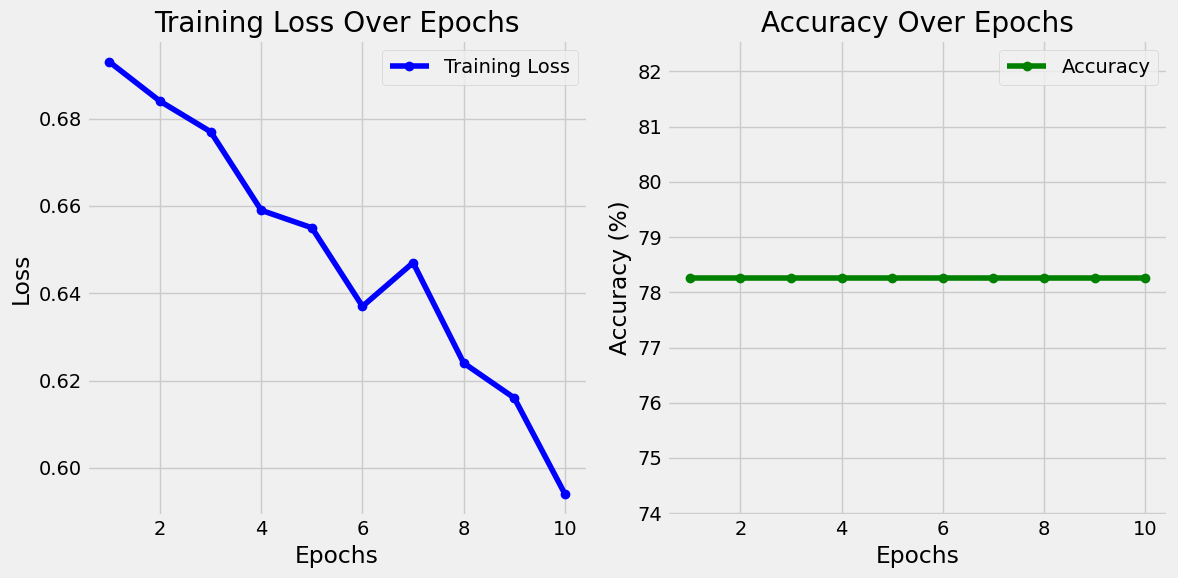

In [59]:
import matplotlib.pyplot as plt

# Sample data for demonstration
epochs = list(range(1, num_epochs + 1))
train_losses = [0.693, 0.684, 0.677, 0.659, 0.655, 0.637, 0.647, 0.624, 0.616, 0.594]  # Example values
accuracies = [78.26] * num_epochs  # Example accuracy

# Plot training loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o', color='blue', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, marker='o', color='green', label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

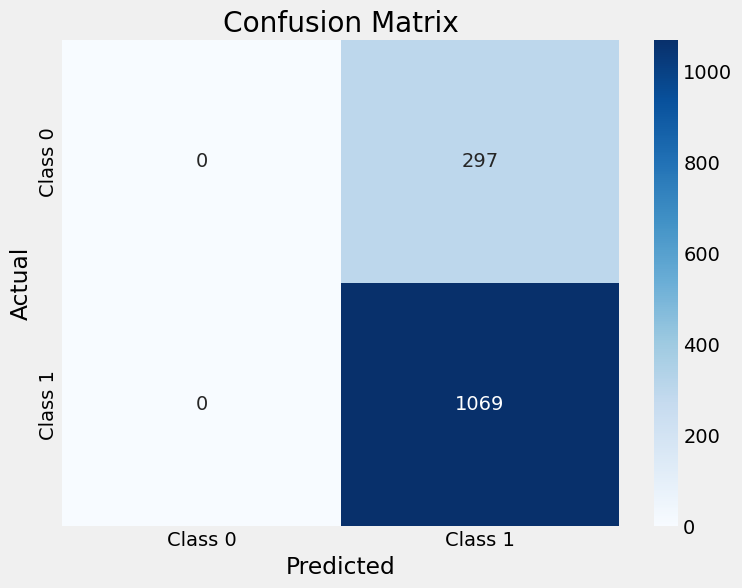

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert lists to numpy arrays
true_labels = np.array(all_labels).flatten()
predicted_labels = (np.array(all_preds).flatten() >= 0.5).astype(int)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

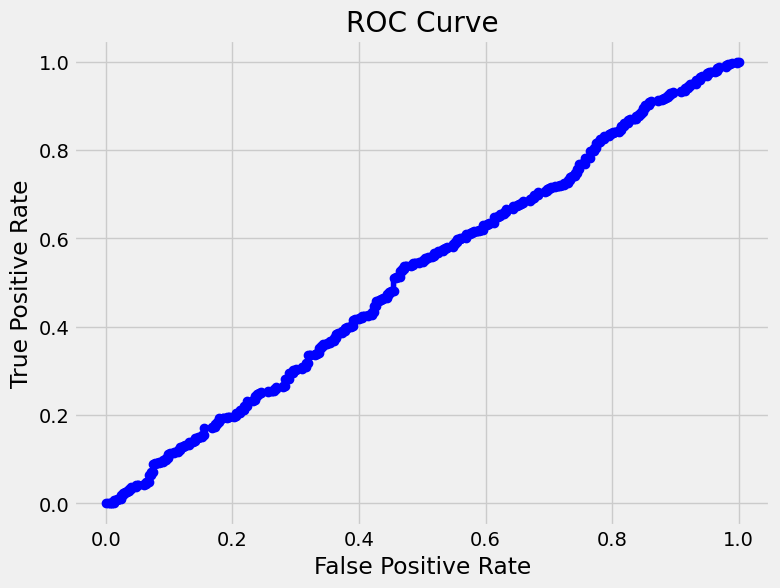

In [61]:
from sklearn.metrics import roc_curve

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, np.array(all_preds).flatten())

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='o', linestyle='-', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.show()

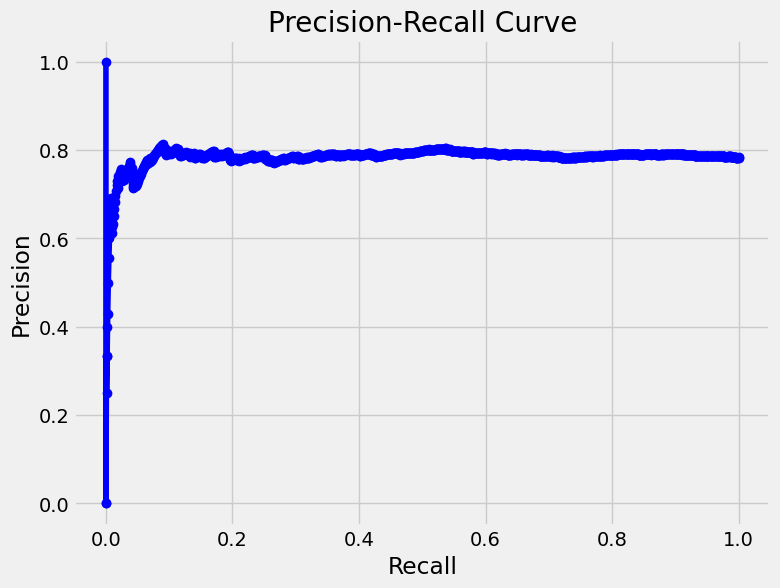

In [62]:
from sklearn.metrics import precision_recall_curve

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(true_labels, np.array(all_preds).flatten())

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='o', linestyle='-', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

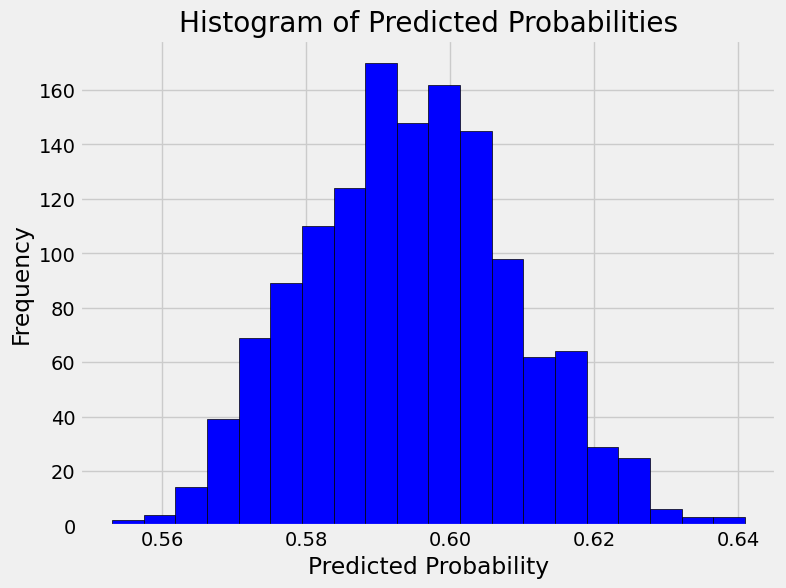

In [63]:
# Plot histogram of predicted probabilities
plt.figure(figsize=(8, 6))
plt.hist(np.array(all_preds).flatten(), bins=20, color='blue', edgecolor='black')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.grid(True)
plt.show()

In [ ]:
#Sample Script to compare similarity performance between pairwise similarity or euclidean distance using human coded as reference-  need some manually coded data to be uploaded as "human_judgments"

from scipy.stats import spearmanr

# Assuming human_judgments is a list of similarity scores
# Flatten matrices for comparison
flattened_cosine = cosine_sim_matrix.numpy().flatten()
flattened_euclidean = euclidean_dist_tensor.numpy().flatten()

# Spearman correlation
spearman_cosine, _ = spearmanr(flattened_cosine, human_judgments)
spearman_euclidean, _ = spearmanr(flattened_euclidean, human_judgments)

print(f"Spearman Correlation (Cosine Similarity): {spearman_cosine}")
print(f"Spearman Correlation (Euclidean Distance): {spearman_euclidean}")

NameError: name 'human_judgments' is not defined